In [1]:
# EDA and data handling
import numpy as np 
import pandas as pd 
import pickle

import os
import matplotlib.pyplot as plt

# Modeling
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics

In [2]:
sklearn.__version__

'0.21.2'

In [3]:
movies = pd.read_csv('../data/tmdb_movie_plots.csv')
movies.shape

(3410, 22)

In [4]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,top_genre,year
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Action,2009
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Adventure,2007


In [5]:
movies = movies[['title', 'overview', 'year', 'popularity', 'top_genre']].copy()

In [6]:
# remove unlabeled data
print(movies.shape)
movies=movies.dropna(how='any')
print(movies.shape)

(3410, 5)
(3409, 5)


In [7]:
# columns
movies.columns

Index(['title', 'overview', 'year', 'popularity', 'top_genre'], dtype='object')

### Preprocess text data

In [8]:
tvec = TfidfVectorizer(
#                        input='content', 
#                        encoding='utf-8', 
#                        decode_error='strict', 
                       strip_accents='unicode', 
                       lowercase=True, 
#                        preprocessor=None, 
#                        tokenizer=None, 
#                        analyzer='word', 
                       stop_words='english', 
#                        token_pattern='(?u)\\b\\w\\w+\\b', 
#                        ngram_range=(1,2), 
#                        max_df=1.0, 
#                        min_df=1, 
#                        max_features=None, 
#                        vocabulary=True, 
#                        binary=False, 
#                        dtype=<class 'numpy.int64'>, 
#                        norm='l2', 
#                        use_idf=True, 
#                        smooth_idf=True, 
#                        sublinear_tf=False
)

## Target

In [9]:
# check out the genres
movies['top_genre'].value_counts().head()

Drama        826
Comedy       789
Action       513
Horror       214
Adventure    212
Name: top_genre, dtype: int64

In [10]:
# create the target variable
choice='Horror'
movies['target']=0
movies.loc[movies['top_genre']==choice, 'target']=1
movies['target'].value_counts().sort_index()

0    3195
1     214
Name: target, dtype: int64

In [11]:
# examine a few
movies[movies['target']==1].sample(3)

,title,overview,year,popularity,top_genre,target
2833,Chain Letter,Six friends receive a mysterious chain letter ...,2010,2.504156,Horror,1
3012,Session 9,Tensions rise within an asbestos cleaning crew...,2001,11.064228,Horror,1
2780,2:13,A police profiler has just returned from psych...,2009,1.271621,Horror,1


## Train-test split

In [12]:
np.random.seed(42) 
msk = np.random.rand(len(movies)) < 0.8
train = movies[msk]
test = movies[~msk]
print(len(train))
print(len(test))

2729
680


In [13]:
# How many in the test class?
print(test['target'].value_counts())

0    625
1     55
Name: target, dtype: int64


In [14]:
# How many in the train class?
print(train['target'].value_counts())

0    2570
1     159
Name: target, dtype: int64


In [15]:
# Undersample the majority class
undersample = train[train['target']==0].sample(400, random_state=42)
train_aug=train[train['target']==1].append(undersample)
train_aug['target'].value_counts()

0    400
1    159
Name: target, dtype: int64

In [16]:
# split into X and y
X_train=train_aug['overview']
X_test=test['overview']
y_train=train_aug['target']
y_test=test['target']

In [17]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

559
559
680
680


In [18]:
# Note the difference in train and test. Don't fit on the test data! (d'oh)
tvec.fit(X_train)
Xvec_train = tvec.transform(X_train)
Xvec_test  = tvec.transform(X_test)
# We pickle tvec later on.

In [19]:
# # grid search parameters
# param_grid = {
# #         'n_estimators': [100, 'warn'], 
# #         'max_depth': [3, 4, 5, None],
# #         'min_samples_split': [2, 3, 4, 5],
# #         'min_samples_leaf': [1, 2, 3, 4, 5],         
# #         'max_features': [5, 10, 15, 'auto'], 
# #         'class_weight': [None],
# #         'criterion':['entropy', 'gini'],
#         }

In [20]:
# # conduct gridsearch
# grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, n_jobs = 1, cv=3, verbose=False)
# grid.fit(Xvec_train, y_train)
# print(grid.best_params_)

In [21]:
# # Instantiate model using those parameters
# my_model = grid.best_estimator_
# print(my_model)
# Model parameters
# print(my_model.get_params)

In [22]:
my_model=RandomForestClassifier()
my_model.fit(Xvec_train, y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [23]:
# pickle the RF model
file = open(f'trained_rf_model.pkl', 'wb')
pickle.dump(my_model, file)
file.close()

## Predict & Evaluate

In [24]:
# Predict on the test data
y_preds=my_model.predict(Xvec_test)
print(len(y_test))
len(y_preds)

680


680

In [25]:
# Probabilities
y_probs = my_model.predict_proba(Xvec_test)[:,1]
len(y_probs)

680

In [26]:
# Accuracy score
metrics.accuracy_score(y_test, y_preds)

0.9029411764705882

In [27]:
# precision and recall 
print(metrics.classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       625
           1       0.37      0.29      0.33        55

    accuracy                           0.90       680
   macro avg       0.66      0.62      0.64       680
weighted avg       0.89      0.90      0.90       680



In [28]:
# confusion matrix
cm = metrics.confusion_matrix(y_test, y_preds)
pd.DataFrame(cm, columns=['pred_0', 'pred_1'])

,pred_0,pred_1
0,598,27
1,39,16


In [29]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_preds).ravel()
print(tn, fp, fn, tp)

598 27 39 16


## ROCAUC score

In [30]:
from sklearn.metrics import roc_curve, auc

In [31]:
FPR = dict()
TPR = dict()
ROC_AUC = dict()
# For class 1 (has WNV), find the area under the curve:
FPR[1], TPR[1], _ = roc_curve(y_test, y_probs)
ROC_AUC[1] = auc(FPR[1], TPR[1])

In [32]:
# What is that ROC-AUC score?
print(ROC_AUC[1])
# Same but using the scikit default:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_probs)

0.7430254545454545


0.7430254545454545

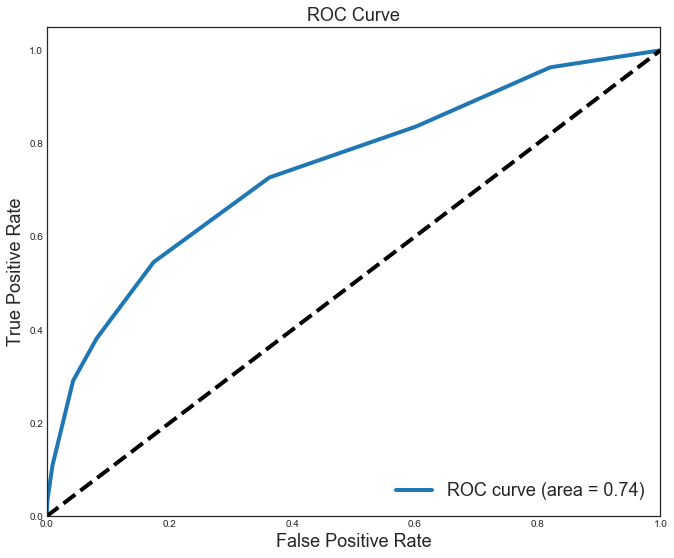

In [33]:
# Let's draw that:
plt.style.use('seaborn-white')
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve', fontsize=18)
plt.legend(loc="lower right", fontsize=18);

## Feature Importance

In [34]:
df_x  = pd.DataFrame(Xvec_test.todense(),
             columns=tvec.get_feature_names())

In [35]:
fi = pd.DataFrame({
        'feature':df_x.columns,
        'importance':my_model.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)

In [48]:
# Features most associated with target
top20=pd.DataFrame(fi.sort_values('importance', ascending=False).head(20))
print(top20['feature'].values)
top20

['horror' 'spirit' 'weekend' 'group' 'left' 'evil' 'deadly' 'battle'
 'mysterious' 'possession' 'people' 'disappeared' 'vicious' 'virus'
 'house' 'remote' 'lake' 'lies' 'horrifying' 'terrifying']


,feature,importance
2656,horror,0.013783
5109,spirit,0.010826
5947,weekend,0.010254
2440,group,0.010045
3169,left,0.009391
1927,evil,0.008940
1424,deadly,0.008866
545,battle,0.008688
3674,mysterious,0.007779
4151,possession,0.007747


Text(0, 0.5, 'Feature Importance')

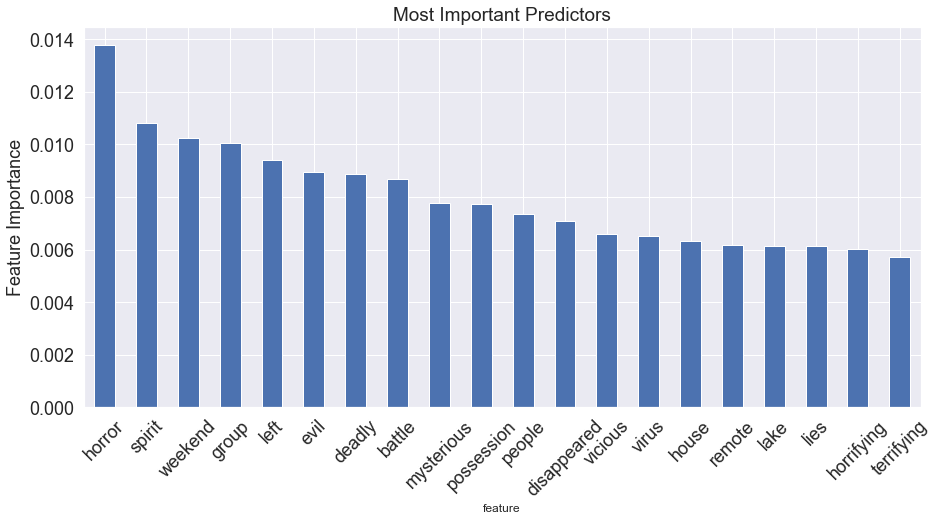

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="darkgrid", color_codes=None)
# sns.palplot(sns.color_palette("RdBu", n_colors=7))
ax = top20.set_index('feature').plot(kind='bar', legend=False, fontsize=18,  figsize=(15, 7))
plt.xticks(rotation = 45,  fontsize=18)
plt.title('Most Important Predictors',  fontsize=19)
plt.yticks(rotation = 0,  fontsize=18)
plt.ylabel('Feature Importance', rotation=90,  fontsize=18)

In [51]:
# save that dataframe
top20.to_csv('top20.csv', index=False)

In [56]:
# Let's display that with Plotly.
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
# import plotly.io as pio
import plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import *

# Define the color palette (19 colors).
Viridis= ['#440154', '#48186a', '#472d7b', '#424086', '#3b528b', '#33638d', '#2c728e', '#26828e', '#21918c', '#1fa088',
          '#28ae80', '#3fbc73', '#5ec962', '#84d44b', '#84d44b', '#addc30','#d8e219', '#fde725',  '#fde725']   

mydata = [go.Bar(
    x=top20['feature'],
    y=top20['importance'],
    marker=dict(color=Viridis[::-1])
)]

mylayout = go.Layout(
    title='What makes it a horror film?',
    xaxis = dict(title = 'Feature Importance'), 
    yaxis = dict(title = 'Top Words'), 

)
fig = go.Figure(data=mydata, layout=mylayout)
# pio.write_image(fig, '../images/logistic.png')
iplot(fig)

In [59]:
# A confusion matrix tells us our false positives and false negatives:
matrix=metrics.confusion_matrix(y_test, y_preds)
cm=pd.DataFrame(matrix, columns=['predicted: no', 'predicted: yes'], index=['ground truth: no', 'ground truth: yes'])
cm=cm.reset_index(drop=False)
cm=cm.rename(columns={'index': f'n = {len(y_test)}'})

In [60]:
import plotly.figure_factory as ff
table = ff.create_table(cm)
iplot(table)

In [62]:
cm.to_csv('conf_matrix.csv', index=False)
cm

,n = 680,predicted: no,predicted: yes
0,ground truth: no,598,27
1,ground truth: yes,39,16


## Test on new data

In [38]:
# newdata = train[train['target']==1]['overview'].sample(1).values
newdata = ['this is a test this is just a test funny funny joke ha']
tvec_test=tvec.transform(newdata)
preds_test=my_model.predict(tvec_test)
preds_test

array([0])

In [39]:
# pickle the vectorizer
file = open('vectorizer.pkl', 'wb')
pickle.dump(tvec, file)
file.close()